## Importing the necessary libraries

In [11]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import cv2
import matplotlib.pyplot as plt

## Installing RetinaFace model for face detection

In [ ]:
!pip install insightface

In [ ]:
!pip install onnxruntime-gpu

## Initializing the Face Detector

In [ ]:
# Import the insightface library
import insightface

# Create an instance of the FaceAnalysis class from the insightface library
detector = insightface.app.FaceAnalysis()

# Prepare the face detector with the specified context ID (0 indicates using the default GPU)
detector.prepare(ctx_id=0)

## Marking the Face using a box

In [2]:
# Import the matplotlib library for plotting and patches for drawing shapes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define a function to detect faces in a given frame
def detect_faces(frame):
    # Use the detector to get faces in the frame
    faces = detector.get(frame)
    
    # Initialize an empty list to store the results
    results = []
    
    # Check if any faces are detected
    if faces:
        # Iterate over each detected face
        for face in faces:
            # Get the bounding box of the face and convert to integer type
            bbox = face['bbox'].astype(int)
            
            # Extract coordinates from the bounding box
            x, y, x2, y2 = bbox
            
            # Calculate the width and height of the bounding box
            width = x2 - x
            height = y2 - y
            
            # Append the coordinates and dimensions to the results list
            results.append((x, y, width, height))
    
    # Return the list of results
    return results

In [3]:
# Define a function to plot faces and zoom into the region containing the faces
def plot_faces_and_zoom(frame, results):
    # Check if there are detected faces
    if results:  
        # Create a figure and axis for the plot
        fig, ax = plt.subplots()
        
        # Display the image in RGB format (OpenCV loads images in BGR format by default)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  

        # Find the minimum and maximum coordinates for zooming into the region containing faces
        min_x = min([x for x, y, w, h in results]) - 10
        max_x = max([x + w for x, y, w, h in results]) + 10
        min_y = min([y for x, y, w, h in results]) - 10
        max_y = max([y + h for x, y, w, h in results]) + 10

        # Set the limits for the x and y axes to zoom into the faces region
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(max_y, min_y)  # Inverted to keep the image from flipping upside down

        # Draw rectangles around the detected faces
        for (x, y, w, h) in results:
            # Create a rectangle patch with the face's bounding box coordinates
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Remove the axis for a cleaner look
        ax.axis('off')
        
        # Display the plot
        plt.show()

### The RetinaFace can detect the face even if the image is blurry which is quite useful for video recordings where the face is pixelated.

In [ ]:
# Define the image path
image_path = '/kaggle/input/deblur-the-faces/blurred face of the girl.jpg'

# Read the image from the given path
frame = cv2.imread(image_path)

# Detect faces in the image
results = detect_faces(frame)

# If faces are detected, plot the faces and zoom into the region containing the faces
if results:
    plot_faces_and_zoom(frame, results)

In [ ]:
# Define a function to get frames from a video within a specified time interval
def get_frames_in_interval(video_path, start_second, end_second):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get the frames per second (fps) of the video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Initialize a list to store the frames
    frames = []
    
    # Initialize a counter for the current frame
    current_frame = 0
    
    # Calculate the start and end frames based on the specified start and end times
    start_frame = start_second * fps
    end_frame = end_second * fps
    
    # Loop through the video frames
    while cap.isOpened():
        # Read a frame from the video
        ret, frame = cap.read()
        
        # Break the loop if no more frames are available or if the end frame is reached
        if not ret or current_frame > end_frame:
            break
        
        # If the current frame is within the specified interval, add it to the list
        if current_frame >= start_frame:
            frames.append(frame)
        
        # Increment the current frame counter
        current_frame += 1
    
    # Release the video capture object
    cap.release()
    
    # Return the list of frames
    return frames

## Trying Pixel Average Interpolation to avoid blurring due to motion in the video

In [ ]:
def pixel_average_interpolation(frame1, frame2):
    """Average pixels of two frames."""
    return cv2.addWeighted(frame1, 0.5, frame2, 0.5, 0)

def interpolate_video_frames(video_path, output_path, interpolation_factor=2):
    """
    Interpolates frames by averaging pixels between each consecutive pair of frames,
    increases the frame rate according to the interpolation factor.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    codec = cv2.VideoWriter_fourcc(*'mp4v')  # Codec used to create the output video

    # Create a VideoWriter object
    out = cv2.VideoWriter(output_path, codec, fps * interpolation_factor, (width, height))

    # Read the first frame
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        return

    out.write(prev_frame)

    # Process the video
    while True:
        ret, next_frame = cap.read()
        if not ret:
            break

        # Write interpolated frames
        for i in range(1, interpolation_factor):
            # Since we're averaging, we use a simple 0.5 weight for both frames
            interpolated_frame = pixel_average_interpolation(prev_frame, next_frame)
            out.write(interpolated_frame)

        out.write(next_frame)
        prev_frame = next_frame

    cap.release()
    out.release()
    print("Interpolation complete. Output saved to:", output_path)

video_path = 'add_video_path_here' # We have to change the input video path
output_path = 'interpolated_video.mp4'
interpolate_video_frames(video_path, output_path)

## We can focus on specific portion of the video using start time and end time

In [ ]:
# Get the frames from the video within the specified interval
frames = get_frames_in_interval(os.path.join('/kaggle/working/', output_path), start_time, end_time)

# Iterate over each frame in the list of frames
for frame in frames:
    # Detect faces in the current frame
    results = detect_faces(frame)
    
    # Plot the faces and zoom into the region containing the faces
    plot_faces_and_zoom(frame, results)

## For removing the noise from the image, we will use GAN Prior Embedded Network.

### Let's clone the GitHub repository first

In [4]:
# clone the repository
!rm -rf GPEN
!git clone https://github.com/yangxy/GPEN.git
%cd GPEN

Cloning into 'GPEN'...
remote: Enumerating objects: 671, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 671 (delta 118), reused 110 (delta 109), pack-reused 510
Receiving objects: 100% (671/671), 187.58 MiB | 49.38 MiB/s, done.
Resolving deltas: 100% (187/187), done.
/kaggle/working/GPEN


In [5]:
!pip install -r requirements.txt

In [6]:
!ls

GPEN.ipynb	 examples	       face_parse	     sr_model
README.md	 face_colorization.py  figs		     train_simple.py
__init_paths.py  face_detect	       misc		     training
align_faces.py	 face_enhancement.py   requirements.txt      val
demo.py		 face_inpainting.py    run.sh		     weights
distributed.py	 face_model	       segmentation2face.py


## Put all the models in the weights folder

In [7]:
!cp /kaggle/input/deblur-the-faces/RetinaFace-R50.pth weights
!cp /kaggle/input/deblur-the-faces/GPEN-BFR-512.pth weights
!cp /kaggle/input/deblur-the-faces/ParseNet-latest.pth weights
!cp /kaggle/input/deblur-the-faces/realesrnet_x2.pth weights

In [8]:
!ls weights

GPEN-BFR-512.pth     README.md		 realesrnet_x2.pth
ParseNet-latest.pth  RetinaFace-R50.pth


## Defining the function to display the image

In [9]:
# Import necessary libraries
from __init_paths import *
from face_enhancement import FaceEnhancement
import torch

# Define a function to display images side by side
def display(img1, img2, img3=''):
    # Create a figure with a specified size
    fig = plt.figure(figsize=(15, 10))
    
    # Add the first subplot for the input image
    ax1 = fig.add_subplot(1, 3, 1)
    plt.title('Input image', fontsize=16)
    ax1.axis('off')
    
    # Add the second subplot for the GPEN output image
    ax2 = fig.add_subplot(1, 3, 2)
    plt.title('GPEN output', fontsize=16)
    ax2.axis('off')
    
    # Check if a third image is provided
    if len(img3) == 0:
        # Display the first and second images if no third image is provided
        ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    else:
        # Add the third subplot for the original image
        ax3 = fig.add_subplot(1, 3, 3)
        plt.title('Original Image', fontsize=16)
        ax3.axis('off')
        
        # Display all three images
        ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

/kaggle/working/GPEN/align_faces.py:251: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if align_type is 'cv2_affine':
/kaggle/working/GPEN/align_faces.py:254: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif align_type is 'affine':


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


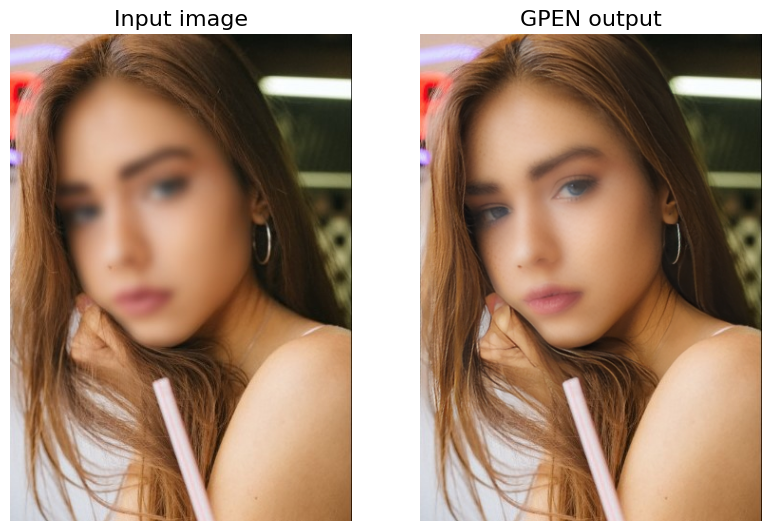

In [12]:
# Create a simple class to mimic argparse.Namespace
class ArgsNamespace:
    def __init__(self, **kwargs):
        # Update the instance dictionary with the provided keyword arguments
        self.__dict__.update(kwargs)

# Manually define the arguments
args = ArgsNamespace(
    channel_multiplier=2,
    model='GPEN-BFR-512',
    task='FaceEnhancement',
    key=None,
    in_size=512,
    out_size=None,
    narrow=1,
    alpha=1,
    use_sr=False,
    use_cuda=True,
    save_face=False,
    aligned=False,
    sr_model='realesrnet',
    sr_scale=2,
    tile_size=0,
    indir='/kaggle/input/deblur-the-faces',
    outdir='/kaggle/working/results',
    ext='.jpg',
    weights_dir='weights'
)

# Create the output directory if it doesn't exist
os.makedirs(args.outdir, exist_ok=True)

# Initialize the FaceEnhancement object with the provided arguments
faceenhancer = FaceEnhancement(
    args,
    in_size=args.in_size,
    model=args.model,
    use_sr=args.use_sr,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Define the input file path and get the filename
file = os.path.join(args.indir, 'blurred face of the girl.jpg')
filename = os.path.basename(file)

# Read the input image in BGR format
img = cv2.imread(file, cv2.IMREAD_COLOR)

# Process the image to get the enhanced output and faces
img_out, orig_faces, enhanced_faces = faceenhancer.process(img, aligned=args.aligned)

# Resize the input image to match the output image's shape
img = cv2.resize(img, img_out.shape[:2][::-1])

# Save the comparison image (input and output side by side)
cv2.imwrite(os.path.join(args.outdir, '.'.join(filename.split('.')[:-1]) + '_COMP.jpg'), np.hstack((img, img_out)))

# Save the GPEN output image
cv2.imwrite(os.path.join(args.outdir, '.'.join(filename.split('.')[:-1]) + '_GPEN.jpg'), img_out)

# Save each original and enhanced face side by side
for m, (ef, of) in enumerate(zip(enhanced_faces, orig_faces)):
    of = cv2.resize(of, ef.shape[:2])
    cv2.imwrite(os.path.join(args.outdir, '.'.join(filename.split('.')[:-1]) + '_face%02d' % m + '.jpg'), np.hstack((of, ef)))

# Display the input and GPEN output images
display(img, img_out)

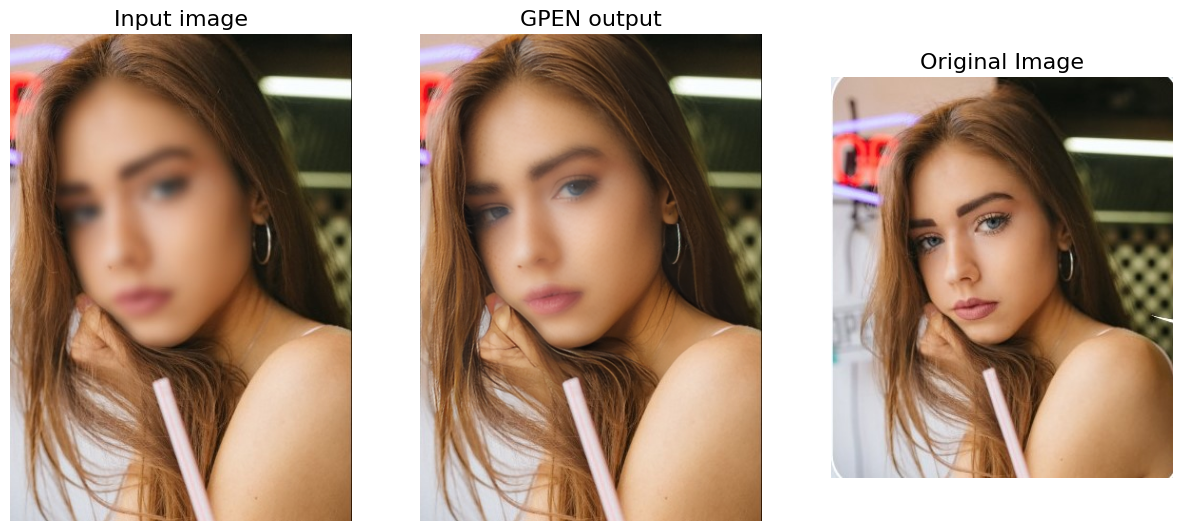

In [13]:
original = cv2.imread('/kaggle/input/deblur-the-faces/unblur face of the girl.jpg', cv2.IMREAD_COLOR)
display(img, img_out, original)